# Class 1 - Phase identification - Single-Bus structure

## Agenda
- Problem Description
- Problem Implementation
- Alternative Problems
- Wrap-Up

## Problem Description

- While the connectivity model of low voltage (LV) grids is usually known, the phase connectivity information of single-phase connected customers is often erroneous or missing. This is due to many reasons including maintenance and other load balancing initiatives that usually do not update phase connectivity information and do not keep track of its changes in a systematic way.

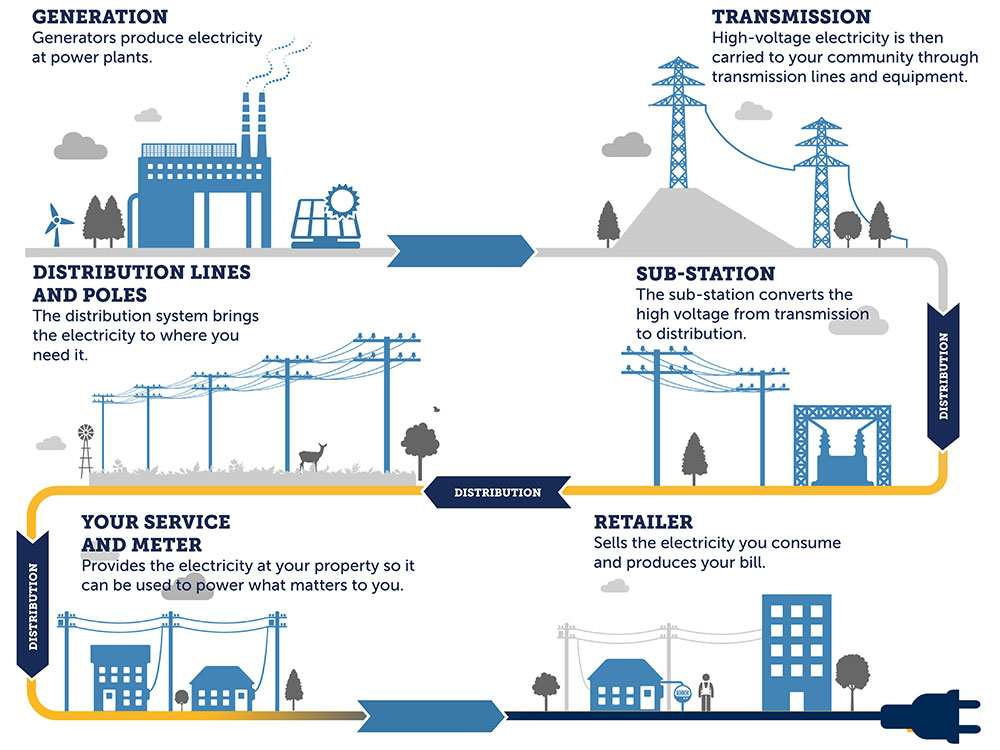

https://www.fortisalberta.com/about-us/our-company/blog/fortisalbertablog/2019/08/20/we-explain-the-complex-sophisticated-system-that-brings-electricity-to-you




- With the deployment of smart metering and the consequent availability
of high-resolution consumption data, phase connectivity
should be possible to estimate if data on per-phase aggregate energy
measurements would be available at substation sites with the
same resolutio.

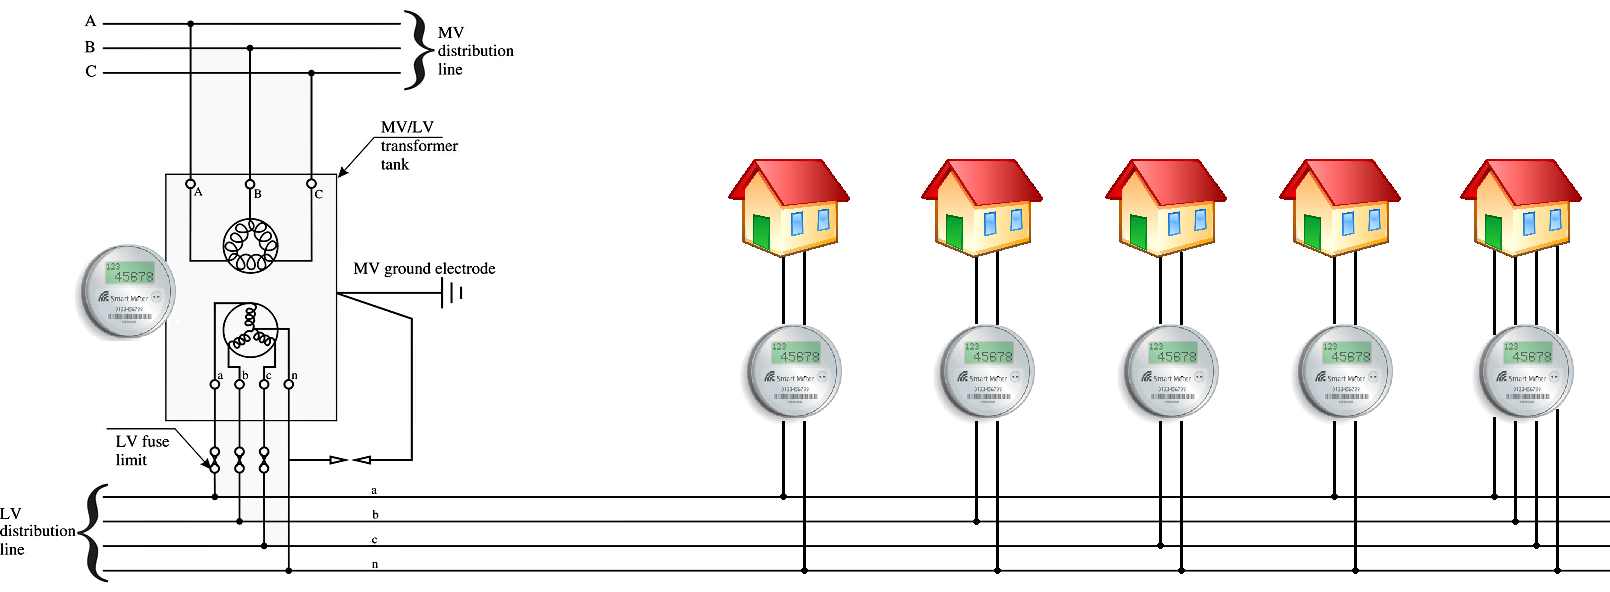

<b>Consider <i>N</i> customers whose connection phase assumes one out of three possible labels <i>a, b, </i> or <i> c</i> and estimate the correct customer-to-label assignment based on <i>M</i> readings whose per-phase values are a <i>function</i> of the corresponding phase-connected individual customer reading.</b>

## Problem Description

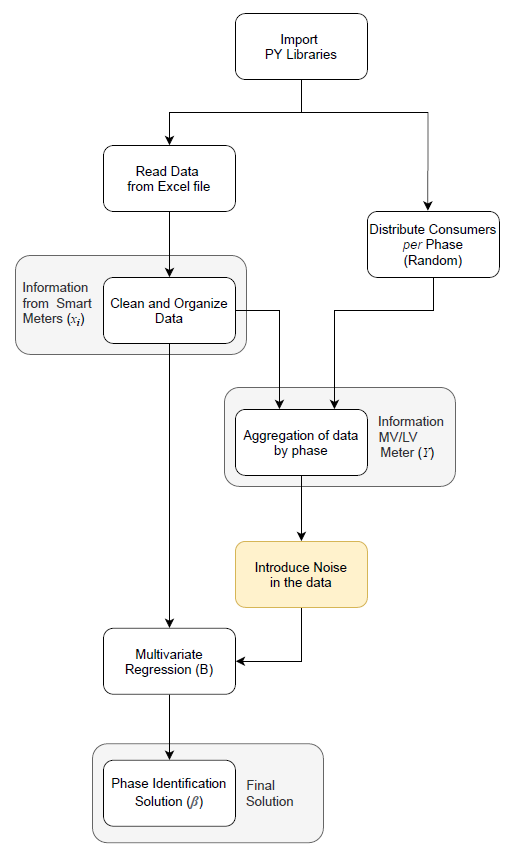

Import Python Libraries

In [4]:
import pandas as pd
import numpy as np
from numpy.random import randint   # To random values in the phases
from numpy.random import random   # To random values in the phases
import matplotlib.pyplot as plt
from numpy import transpose as tr
from numpy.linalg import inv
import matplotlib.pyplot as plt

import networkx as nx
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.sparse import csr_matrix

Parameters (It is possible to change to test different input data)

In [5]:
nc=4                        # Number of consumers (1 to nc)                  %%Data Notes: nc=4
ts=60                       # start period of analysis (Can be from 1 to 96)  %%Data Notes: ts=60
te=71                       # Last period of analysis (Can be from 1 to 96)   %%Data Notes: te=71
phase =[3,2,1,3]            # To obtain the same values of lecture notes
phase_original = phase.copy() 
noise = 0
#phase = randint(1, 4, nc)  # To obtain random values

print ("The distribution of consumers in each phase is: ", phase)

The distribution of consumers in each phase is:  [3, 2, 1, 3]


Import data (From Excel file)

In [6]:
raw_data = np.array(pd.read_excel (r"dataC1.xlsx", header=None))

In [7]:
np.shape(raw_data)

(152756, 2)

Clean and organize the data (delete zeros and organize by consumers)

In [8]:
checks=0
nr=1
data=np.zeros((1,96))
#h=np.arange(1/96, 1, 1/96).tolist()
h=raw_data[0:96,0]
for i in range(1,raw_data.shape[0]+1):
    if i==0:
        print(i)
    if raw_data[i-1,0]==h[checks]:
        checks=checks+1
    else:
        checks=0
    if checks==96:
        if np.sum(raw_data[i-96:i,1])!=0:
            data[nr-1,0:96]=raw_data[i-96:i,1]
            data.resize((nr+1,96))
            nr=nr+1
        checks=0
data.resize((nr-1,96))

print ("The number of consumers is ", data.shape[0], " and the number of periods is ", data.shape[1])

The number of consumers is  1390  and the number of periods is  96


Select data from consumers and period (Truncate the original matrix) 

In [9]:
data_Aux1=data[0:nc,:]
pw=data_Aux1[:,ts-1:te]

print ("The matrix 'pw' represents the power measured by the smart meter in each consumer (i) in each period (k)")
print ("In the lecture notes, this value is represented by X.")
print ("The value of X is:\n",np.transpose(4*pw))   # We should multiply by 4 to obtain the same values of the lectures. 
                                                    # In fact the original values are the average energy consumption for
                                                    # 15 minutes. To obtain the power, we should multiply by 4  



The matrix 'pw' represents the power measured by the smart meter in each consumer (i) in each period (k)
In the lecture notes, this value is represented by X.
The value of X is:
 [[0.332 0.064 0.084 0.12 ]
 [0.236 0.164 0.276 0.064]
 [0.224 0.708 1.572 0.072]
 [0.36  3.44  1.188 0.18 ]
 [1.332 2.176 0.484 1.464]
 [1.516 3.02  0.316 0.624]
 [0.92  0.916 0.404 2.772]
 [0.752 0.64  0.396 1.464]
 [1.828 0.684 0.576 0.576]
 [3.568 0.564 0.828 0.428]
 [0.78  0.356 0.728 0.348]
 [0.856 0.22  0.308 0.12 ]]


Consumers aggregation by phase and noise inclusion (normal distribution).

In [10]:
# Creating X and Y (noiseless)
X=np.transpose(4*pw)
Y=np.zeros((len(X),3))
Y[:,0]=X[:,2]
Y[:,1]=X[:,1]
Y[:,2]=X[:,0]+X[:,3]

# passing noise to Y
mu=0; sigma=1; # mean and s.d.
Ynoise=np.zeros(np.shape(Y))
for i in range(len(Y[:,0])):
    for j in range(len(Y[0])):
        epsilon=np.random.normal(mu,sigma)
        Ynoise[i,j]=Y[i,j]+epsilon
Ynoise

np.savetxt("y_noise.csv", Ynoise, delimiter=" ")

In [11]:
# resume in a function the creation of the matrix X and Y
def createXY(data_Aux1):
    pw = data_Aux1[:,ts-1:te]
    X=np.transpose(4*pw)
    Y=np.zeros((len(X),3))
    Y[:,0]=X[:,2]
    Y[:,1]=X[:,1]
    Y[:,2]=X[:,0]+X[:,3]
    return X,Y

Multivariate Regression 

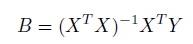

In [12]:
B=inv(tr(X)@X)@tr(X)@Y
for i in range(len(B[:,0])):
    print('client ',i+1,'; phase: ',np.argmax(B[i,:])+1)

client  1 ; phase:  3
client  2 ; phase:  2
client  3 ; phase:  1
client  4 ; phase:  3


In [13]:
print('original results were in fact: ',phase)

original results were in fact:  [3, 2, 1, 3]


# Automating everything for the error evolution Plot

In [14]:
# parâmetros originaiss

ts=60                          # start period of analysis (Can be from 1 to 96)  %% Data Notes: ts=60
te=71                          # Last period of analysis (Can be from 1 to 96)   %% Data Notes: te=71
#phase = np.array([3,2,1,3])   # To obtain the same values of lecture notes      %% Data Notes: [3,2,1,3]
#nc=12                         # Number of consumers (1 to nc)                   %% Data Notes: nc=4
#phase = randint(1, 4, nc)     # To obtain random values

# noise parameters
mu=0; # mean and s.d.
sigma = (np.arange(0,1.1,0.1))**(1/2) # s.d.
# customer parameters
n_customers=[4,6,8,12,16]
n_customer_plots=np.zeros((len(n_customers),len(sigma)))
current_plot=0
for nc in n_customers:
    
    phase = randint(1, 4, nc)  # establishing the phase results
    
    
    # automatizing phases
    phase1=np.where(phase==1)[0]
    phase2=np.where(phase==2)[0]
    phase3=np.where(phase==3)[0]
    
    # creating the true correct beta matrix, for posterior tests
    true_B=np.zeros((nc,3)) # n_customers × n_phases
    for i in range(nc):
        true_B[i,phase[i]-1]=1
    
    
    # data arrangement
    checks=0
    nr=1
    data=np.zeros((1,96))
    #h=np.arange(1/96, 1, 1/96).tolist()
    h=raw_data[0:96,0]
    for i in range(1,raw_data.shape[0]+1):
        if i==0:
            print(i)
        if raw_data[i-1,0]==h[checks]:
            checks=checks+1
        else:
            checks=0
        if checks==96:
            if np.sum(raw_data[i-96:i,1])!=0:
                data[nr-1,0:96]=raw_data[i-96:i,1]
                data.resize((nr+1,96))
                nr=nr+1
            checks=0
    data.resize((nr-1,96))
    
    # truncating the original matrix
    data_Aux1=data[0:nc,:]
    pw=data_Aux1[:,ts-1:te]
    
    # Creating X and Y (noiseless)
    X=np.transpose(4*pw)
    Y=np.zeros((len(X),3))
    # phase 1
    for i in range(len(phase1)):
            Y[:,0]+=X[:,phase1[i]]
    # phase 2
    for i in range(len(phase2)):
            Y[:,1]+=X[:,phase2[i]]
    # phase 3  
    for i in range(len(phase3)):
            Y[:,2]+=X[:,phase3[i]]
    
    
    # iterating on each sigma^2 noise variance value
    plots_probs=np.zeros(len(sigma))
    for k in range(len(sigma)):
        
        # now we will iterate for the same noise sigma and number of clients nc
        # in order to estimate the error probability for such conditions
        n_exp=50 # such number of times
        list_probs=np.zeros(n_exp)
        for kk in range(n_exp): 
            
            # passing noise to Y
            Ynoise=np.zeros(np.shape(Y))
            for i in range(len(Y[:,0])):
                for j in range(len(Y[0])):
                    epsilon=np.random.normal(mu,sigma[k])
                    Ynoise[i,j]=Y[i,j]+epsilon
            
            # applying regression
            B=inv(tr(X)@X)@tr(X)@Ynoise
            pred_B=np.zeros(B.shape)
            for i in range(len(B[:,0])):
                pred_B[i,np.argmax(B[i,:])]=1
            
            # evaluating the error of the prediction (true_B has the true values, pred_B has the predicted ones)
            dif_B=true_B-pred_B
            prob_error=0
            for i in range(len(dif_B[:,0])):
                if np.any(dif_B[i]):
                    prob_error+=1/nc
                    
            # storing every atomic P(error) so we can average them out and get a better estimation
            list_probs[kk]=prob_error
        # storing this mean as our P(error) for 
        plots_probs[k]=list_probs.mean()
    # getting each plot of the P(error) for each number of customers nc        
    n_customer_plots[current_plot]=plots_probs
    current_plot+=1

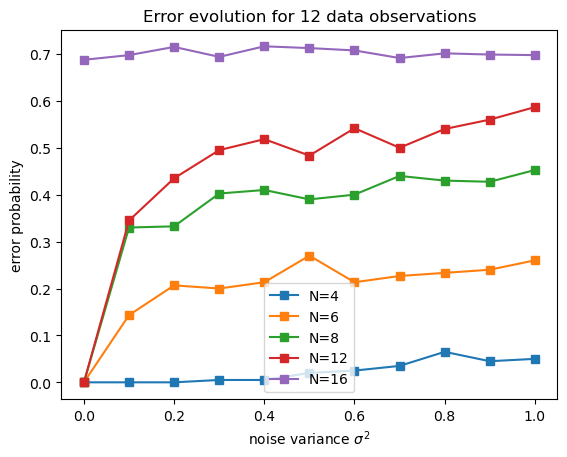

In [15]:
# finally plotting the error
fig, ax = plt.subplots()
ax.plot(sigma**2, n_customer_plots.T,'s-')

ax.legend(('N=4', 'N=6', 'N=8','N=12','N=16'))

ax.set(xlabel='noise variance $\sigma^2$', ylabel='error probability',
       title='Error evolution for 12 data observations')

plt.show()

# Extra Challenges
Think about an interesting variation to this problem or a different way to solve and implement it !!!

Some ideas:
- What happens if we have two consumers with the same consumption ? What about if the difference is very small ? Can we quantify the sensitivity ?
- What happens if we have three-phase clients ? Can we follow the same approach ?

.
.
.
.


In answer to the first question, if two consumers have the same consumption, then X is linearly dependent on two of its columns, thus $X^\top X$ will be singular, and thus normal regression won't work.

.
.
.
.

Regardless, we can for example use Ridge Regression to ameliorate this problem.


.

Let's then tackle the "same consumption" customer problem?

We'll solve it only for the case of having ONE more customer with the SAME (or almost same) CONSUMPTION as the $1^{st}$ customer.

In [16]:
# parâmetros originaiss

ts=60                          # start period of analysis (Can be from 1 to 96)  %% Data Notes: ts=60
te=71                          # Last period of analysis (Can be from 1 to 96)   %% Data Notes: te=71
#phase = np.array([3,2,1,3])   # To obtain the same values of lecture notes      %% Data Notes: [3,2,1,3]
#nc=12                         # Number of consumers (1 to nc)                   %% Data Notes: nc=4
#phase = randint(1, 4, nc)     # To obtain random values

# noise parameters
mu=0; # mean and s.d.
sigma = (np.arange(0,1.1,0.1))**(1/2) # s.d.
# customer parameters
n_customers=[4,6,8,12,16]
n_customer_plots=np.zeros((len(n_customers),len(sigma)))
current_plot=0
for nc in n_customers:
    
    phase = randint(1, 4, nc)  # establishing the phase results
    
    ### correcting the last custommer's phase, since he'll be the same as c_1
    phase[-1]=phase[0]
    
    # automatizing phases
    phase1=np.where(phase==1)[0]
    phase2=np.where(phase==2)[0]
    phase3=np.where(phase==3)[0]
    
    # creating the true correct beta matrix, for posterior tests
    true_B=np.zeros((nc,3)) # n_customers × n_phases
    for i in range(nc):
        true_B[i,phase[i]-1]=1
    
    
    # data arrangement
    checks=0
    nr=1
    data=np.zeros((1,96))
    #h=np.arange(1/96, 1, 1/96).tolist()
    h=raw_data[0:96,0]
    for i in range(1,raw_data.shape[0]+1):
        if i==0:
            print(i)
        if raw_data[i-1,0]==h[checks]:
            checks=checks+1
        else:
            checks=0
        if checks==96:
            if np.sum(raw_data[i-96:i,1])!=0:
                data[nr-1,0:96]=raw_data[i-96:i,1]
                data.resize((nr+1,96))
                nr=nr+1
            checks=0
    data.resize((nr-1,96))
    
    # truncating the original matrix
    data_Aux1=data[0:nc,:]
    pw=data_Aux1[:,ts-1:te]
    
    # Creating X and Y (noiseless)
    X=np.transpose(4*pw)
    
    ### Changing X's last customer to c_1's values
    X[:,-1]=X[:,0]
    
    Y=np.zeros((len(X),3))
    # phase 1
    for i in range(len(phase1)):
            Y[:,0]+=X[:,phase1[i]]
    # phase 2
    for i in range(len(phase2)):
            Y[:,1]+=X[:,phase2[i]]
    # phase 3  
    for i in range(len(phase3)):
            Y[:,2]+=X[:,phase3[i]]
    
    
    # iterating on each sigma^2 noise variance value
    plots_probs=np.zeros(len(sigma))
    for k in range(len(sigma)):
        
        # now we will iterate for the same noise sigma and number of clients nc
        # in order to estimate the error probability for such conditions
        n_exp=50 # such number of times
        list_probs=np.zeros(n_exp)
        for kk in range(n_exp): 
            
            # passing noise to Y
            Ynoise=np.zeros(np.shape(Y))
            for i in range(len(Y[:,0])):
                for j in range(len(Y[0])):
                    epsilon=np.random.normal(mu,sigma[k])
                    Ynoise[i,j]=Y[i,j]+epsilon
            
            ### applying RIDGE regression
            lamb=0.01
            B=inv(X.T@X+lamb*np.identity(len(X.T@X)))@X.T@Ynoise
            pred_B=np.zeros(B.shape)
            for i in range(len(B[:,0])):
                pred_B[i,np.argmax(B[i,:])]=1
            
            # evaluating the error of the prediction (true_B has the true values, pred_B has the predicted ones)
            dif_B=true_B-pred_B
            prob_error=0
            for i in range(len(dif_B[:,0])):
                if np.any(dif_B[i]):
                    prob_error+=1/nc
                    
            # storing every atomic P(error) so we can average them out and get a better estimation
            list_probs[kk]=prob_error
        # storing this mean as our P(error) for 
        plots_probs[k]=list_probs.mean()
    # getting each plot of the P(error) for each number of customers nc        
    n_customer_plots[current_plot]=plots_probs
    current_plot+=1

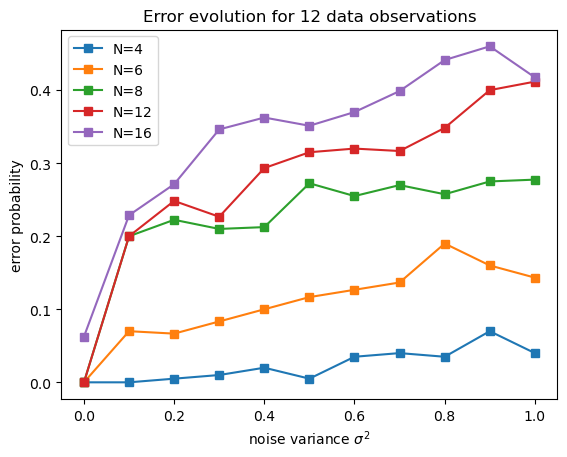

In [17]:
# finally plotting the error
fig, ax = plt.subplots()
ax.plot(sigma**2, n_customer_plots.T,'s-')

ax.legend(('N=4', 'N=6', 'N=8','N=12','N=16'))

ax.set(xlabel='noise variance $\sigma^2$', ylabel='error probability',
       title='Error evolution for 12 data observations')

plt.show()

.

Finally, for now, we tackle the "tri-phasic" customer problem.

We'll solve it only for the case of having ONE more customer with the TRI-PHASIC consumption.

Our solution is rather simple: we assume this tri-phasic customer will be consuming from each phase uniformly. As such, we divide his/her consumption values uniformly (1/3,1/3,1/3) and do everything else as usual.

In [18]:
# parâmetros originaiss

ts=60                          # start period of analysis (Can be from 1 to 96)  %% Data Notes: ts=60
te=71                          # Last period of analysis (Can be from 1 to 96)   %% Data Notes: te=71
#phase = np.array([3,2,1,3])   # To obtain the same values of lecture notes      %% Data Notes: [3,2,1,3]
#nc=12                         # Number of consumers (1 to nc)                   %% Data Notes: nc=4
#phase = randint(1, 4, nc)     # To obtain random values

# noise parameters
mu=0; # mean and s.d.
sigma = (np.arange(0,1.1,0.1))**(1/2) # s.d.
# customer parameters
n_customers=[4,6,8,12,16]
n_customer_plots=np.zeros((len(n_customers),len(sigma)))
current_plot=0
for nc in n_customers:
    
    phase = randint(1, 4, nc)  # establishing the phase results
    
    ### now we make it so that the last customer is tri-phasic
    phase=np.delete(phase,-1)
    
    # automatizing phases
    phase1=np.where(phase==1)[0]
    phase2=np.where(phase==2)[0]
    phase3=np.where(phase==3)[0]
    
    # creating the true correct beta matrix, for posterior tests
    true_B=np.zeros((nc,3)) # n_customers × n_phases
    for i in range(nc-1):
        true_B[i,phase[i]-1]=1
        
    ### deleting the tri-phasic client's beta values
    true_B=np.delete(true_B,-1,axis=0)
    
    # data arrangement
    checks=0
    nr=1
    data=np.zeros((1,96))
    #h=np.arange(1/96, 1, 1/96).tolist()
    h=raw_data[0:96,0]
    for i in range(1,raw_data.shape[0]+1):
        if i==0:
            print(i)
        if raw_data[i-1,0]==h[checks]:
            checks=checks+1
        else:
            checks=0
        if checks==96:
            if np.sum(raw_data[i-96:i,1])!=0:
                data[nr-1,0:96]=raw_data[i-96:i,1]
                data.resize((nr+1,96))
                nr=nr+1
            checks=0
    data.resize((nr-1,96))
    
    # truncating the original matrix
    data_Aux1=data[0:nc,:]
    pw=data_Aux1[:,ts-1:te]
    
    # Creating X and Y (noiseless)
    X=np.transpose(4*pw)
    Y=np.zeros((len(X),3))
    # phase 1
    for i in range(len(phase1)):
            Y[:,0]+=X[:,phase1[i]]
    # phase 2
    for i in range(len(phase2)):
            Y[:,1]+=X[:,phase2[i]]
    # phase 3  
    for i in range(len(phase3)):
            Y[:,2]+=X[:,phase3[i]]
            
    ### adding the tri-phasic customer (assuming uniform consumption)
    for i in range(len(Y[0])):
        Y[:,i]+=1/3*X[:,-1]
    
    
    # iterating on each sigma^2 noise variance value
    plots_probs=np.zeros(len(sigma))
    for k in range(len(sigma)):
        
        # now we will iterate for the same noise sigma and number of clients nc
        # in order to estimate the error probability for such conditions
        n_exp=50 # such number of times
        list_probs=np.zeros(n_exp)
        for kk in range(n_exp): 
            
            # passing noise to Y
            Ynoise=np.zeros(np.shape(Y))
            for i in range(len(Y[:,0])):
                for j in range(len(Y[0])):
                    epsilon=np.random.normal(mu,sigma[k])
                    Ynoise[i,j]=Y[i,j]+epsilon
            
            # applying regression
            B=inv(tr(X)@X)@tr(X)@Ynoise
            pred_B=np.zeros(B.shape)
            for i in range(len(B[:,0])):
                pred_B[i,np.argmax(B[i,:])]=1
                
            ### deleting the tri-phasic client's beta values
            pred_B=np.delete(pred_B,-1,axis=0)
            
            # evaluating the error of the prediction (true_B has the true values, pred_B has the predicted ones)
            dif_B=true_B-pred_B
            prob_error=0
            for i in range(len(dif_B[:,0])):
                if np.any(dif_B[i]):
                    prob_error+=1/nc
                    
            # storing every atomic P(error) so we can average them out and get a better estimation
            list_probs[kk]=prob_error
        # storing this mean as our P(error) for 
        plots_probs[k]=list_probs.mean()
    # getting each plot of the P(error) for each number of customers nc        
    n_customer_plots[current_plot]=plots_probs
    current_plot+=1

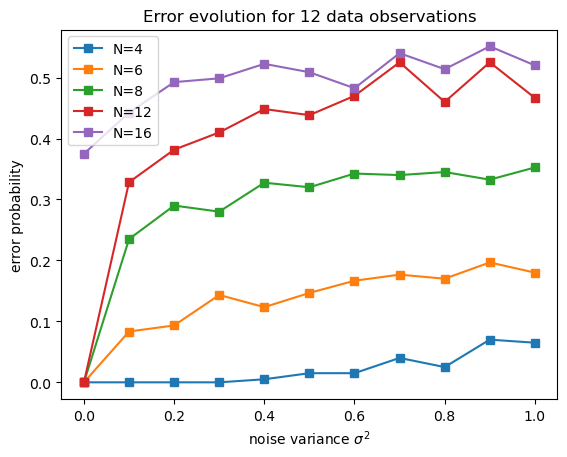

In [19]:
# finally plotting the error
fig, ax = plt.subplots()
ax.plot(sigma**2, n_customer_plots.T,'s-')

ax.legend(('N=4', 'N=6', 'N=8','N=12','N=16'))

ax.set(xlabel='noise variance $\sigma^2$', ylabel='error probability',
       title='Error evolution for 12 data observations')

plt.show()

# Final Project

## Graph optimization problem

### First understanding of handling graphs and performing the min_span_tree algorithm

In [204]:
node_names = ['A', 'B', 'C', 'D']
X_graph = csr_matrix([[0, 8, 0, 3],
                [8, 0, 2, 5],
                [0, 2, 0, 6],
                [3, 5, 6, 0]])
Tcsr = minimum_spanning_tree(X_graph)
Tcsr.toarray().astype(int)



array([[0, 0, 0, 3],
       [0, 0, 2, 5],
       [0, 0, 0, 0],
       [0, 0, 0, 0]])

[[0 0 0 3]
 [0 0 2 5]
 [0 2 0 0]
 [3 5 0 0]]


/home/caria/anaconda3/lib/python3.10/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


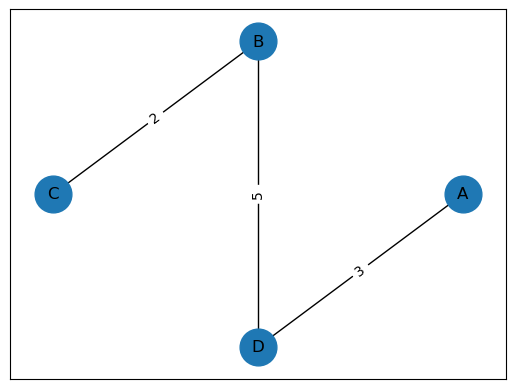

In [206]:
import heapq
from scipy.sparse import csr_matrix



node_names = ['A', 'B', 'C', 'D']
X_graph = csr_matrix([[0, 8, 0, 3],
                      [8, 0, 2, 5],
                      [0, 2, 0, 6],
                      [3, 5, 6, 0]])

mst_prim = prim(X_graph)
print(mst_prim.toarray().astype(int))

display_graph(mst_prim, node_names)


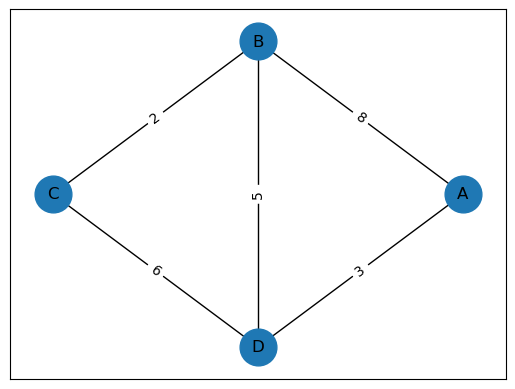

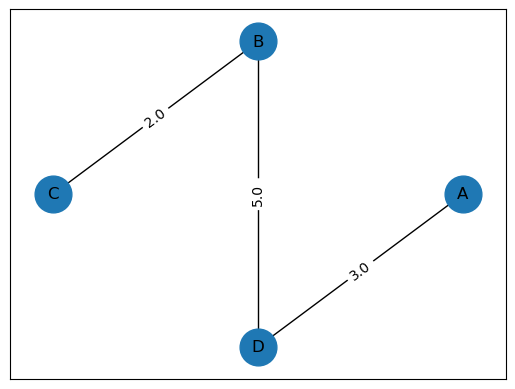

In [21]:
def display_graph(X, node_names=None):
    G = nx.Graph()
    G.add_edges_from([(i, j, {'weight': X[i, j]}) for i in range(X.shape[0]) for j in range(X.shape[1]) if X[i, j] > 0])
    
    # Calculate fixed positions for the nodes in a circular layout
    num_nodes = X.shape[0]
    angles = np.linspace(0, 2 * np.pi, num_nodes + 1)[:-1]
    pos = {i: (np.cos(angle), np.sin(angle)) for i, angle in enumerate(angles)}
    
    nx.draw_networkx_nodes(G, pos, node_size=700)
    nx.draw_networkx_edges(G, pos)
    
    # Format edge weights with 2 decimal places
    edge_labels = {(i, j): round(X[i, j], 2) for i in range(X.shape[0]) for j in range(X.shape[1]) if X[i, j] > 0}
    
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    
    if node_names is not None:
        assert len(node_names) == X.shape[0], "The length of node_names must match the number of nodes in X"
        nx.draw_networkx_labels(G, pos, labels={i: node_names[i] for i in range(X.shape[0])})
    
    plt.show()

display_graph(X_graph,node_names)
display_graph(Tcsr.toarray(),node_names)


### Defining X,Y so we can redo this.

In [164]:
def createXY(raw_data,phase,sigma):
    # parâmetros originaiss

    ts=60                          # start period of analysis (Can be from 1 to 96)  %% Data Notes: ts=60
    te=71                          # Last period of analysis (Can be from 1 to 96)   %% Data Notes: te=71
    #phase = np.array([3,2,1,3])   # To obtain the same values of lecture notes      %% Data Notes: [3,2,1,3]
    #nc=12                         # Number of consumers (1 to nc)                   %% Data Notes: nc=4
    #phase = randint(1, 4, nc)     # To obtain random values

    # noise parameters
    #mu=0; # mean and s.d.
    #sigma = (0.1)**(1/2) # s.d.

    # customer parameters
    # nc = 4 # number of customers
    nc = len(phase) # number of customers
        
    #phase = randint(1, 4, nc)  # establishing the phase results
        
        
    # automatizing phases
    phase1=np.where(phase==1)[0]
    phase2=np.where(phase==2)[0]
    phase3=np.where(phase==3)[0]
    # automating them even more
    


    # data arrangement
    checks=0
    nr=1
    data=np.zeros((1,96))
    #h=np.arange(1/96, 1, 1/96).tolist()
    h=raw_data[0:96,0]
    for i in range(1,raw_data.shape[0]+1):
        if i==0:
            print(i)
        if raw_data[i-1,0]==h[checks]:
            checks=checks+1
        else:
            checks=0
        if checks==96:
            if np.sum(raw_data[i-96:i,1])!=0:
                data[nr-1,0:96]=raw_data[i-96:i,1]
                data.resize((nr+1,96))
                nr=nr+1
            checks=0
    data.resize((nr-1,96))
        
    # truncating the original matrix
    data_Aux1=data[0:nc,:]
    pw=data_Aux1[:,ts-1:te]
        
    # Creating X and Y (noiseless)
    X=np.transpose(4*pw)
    Y=np.zeros((len(X),3))
    # phase 1
    for i in range(len(phase1)):
            Y[:,0]+=X[:,phase1[i]]
    # phase 2
    for i in range(len(phase2)):
            Y[:,1]+=X[:,phase2[i]]
    # phase 3  
    for i in range(len(phase3)):
            Y[:,2]+=X[:,phase3[i]]

    # passing noise to Y
    mu = 0
    # sigma is passed as argument
    Ynoise=np.zeros(np.shape(Y))
    for i in range(len(Y[:,0])):
        for j in range(len(Y[0])):
            epsilon=np.random.normal(mu,sigma)
            Ynoise[i,j]=Y[i,j]+epsilon

    return X,Ynoise




### Defining functions for weigths, creating graphs, mst, final_graph, phase id.

In [244]:
def weight_abs(client_i,phase_j,time_k,X,Y):
    return 1+np.abs(X[time_k,client_i]-Y[time_k,phase_j])

def weight_square(client_i,phase_j,time_k,X,Y):
    return 1+(X[time_k,client_i]-Y[time_k,phase_j])**2

def weight_normalized_abs(client_i,phase_j,time_k,X,Y):
    return 1+np.abs(X[time_k,client_i]-Y[time_k,phase_j])/np.abs(Y[time_k,phase_j])

# another weight, the normalized version of the square
def weight_normalized_square(client_i,phase_j,time_k,X,Y):
    return 1+(X[time_k,client_i]-Y[time_k,phase_j])**2/np.abs(Y[time_k,phase_j])

# another weight, different normalization (by the sum of the phases)
def weight_normalized_sum(client_i,phase_j,time_k,X,Y):
    return 1+np.abs(X[time_k,client_i]-Y[time_k,phase_j])/np.sum(Y[time_k,:])

# another weight, different normalization approach
def weight_normalized(client_i,phase_j,time_k,X,Y):
    return 1+np.abs(X[time_k,client_i]-Y[time_k,phase_j])/np.abs(X[time_k,client_i])


def weight_normalize_phases(client_i, phase_j, time_k, X, Y):
    return 1 + np.abs(X[time_k, client_i] - Y[time_k, phase_j]) / (np.sum(Y[time_k, :]) + 1e-9)

def weight_normalized_time(client_i, phase_j, time_k, X, Y):
    return 1 + np.abs(X[time_k, client_i] - Y[time_k, phase_j]) / (np.sum(Y[:, phase_j]) + 1e-9)





# make it into a function, where the weight function is an argument as well
def create_graph(X,Y,k,weight_function,clients,phases):
    node_length = len(clients)+len(phases)
    matrix_graph = np.zeros((node_length,node_length))
    for i in range(len(clients)):
        for j in range(len(phases)):
            matrix_graph[i,j+len(clients)] = weight_function(i,j,k,X,Y) # first part of the matrix
            matrix_graph[j+len(clients),i] = weight_function(i,j,k,X,Y) # second part of the matrix, the symmetric one
    return matrix_graph

# minimum spanning tree graph
def create_mst_graph(graph):
    Tcsr = minimum_spanning_tree(graph).toarray()
    return Tcsr

import heapq
# another version, but with prim's
def prim(graph):
    num_nodes = graph.shape[0]
    visited = [False] * num_nodes
    num_visited = 0
    mst = csr_matrix((num_nodes, num_nodes), dtype=int)
    edge_queue = []

    def visit(node):
        nonlocal num_visited
        visited[node] = True
        num_visited += 1
        for neighbor in range(num_nodes):
            if graph[node, neighbor] and not visited[neighbor]:
                heapq.heappush(edge_queue, (graph[node, neighbor], node, neighbor))

    visit(0)

    while edge_queue and num_visited < num_nodes:
        weight, node_u, node_v = heapq.heappop(edge_queue)
        if not visited[node_v]:
            mst[node_u, node_v] = weight
            mst[node_v, node_u] = weight
            visit(node_v)

    return mst.toarray()

#######
# get the final graph, where we only take the min edges of each client
def get_final_graph(mst_graph):
    final_graph = mst_graph.copy()
    for i in range(final_graph.shape[0]):
        for j in range(final_graph.shape[1]):
            # here, if row has more than one non-zero element, we only keep its minimum
            if np.count_nonzero(final_graph[i,:]) > 1:
                min = np.min(final_graph[i,:])
                # only keep the minimum (if both values share the same minimum, we keep the first one)
                final_graph[i,:] = np.where(final_graph[i,:] == min, final_graph[i,:], 0)
                
    return final_graph
#
def get_final_graph(mst_graph):
    final_graph = np.zeros(mst_graph.shape)
    
    for i in range(mst_graph.shape[0]):
        row = mst_graph[i, :]
        non_zero_elements = row[row > 0]
        
        if len(non_zero_elements) > 1:
            min_val = np.min(non_zero_elements)
            final_graph[i, :] = np.where(row == min_val, min_val, 0)
        else:
            final_graph[i, :] = row
    
    return final_graph
#
def get_final_graph(mst_graph, clients):
    final_graph = np.zeros(mst_graph.shape)

    for i in range(len(clients)):
        row = mst_graph[i, :]
        non_zero_elements = row[row > 0]

        if len(non_zero_elements) > 1:
            min_val = np.min(non_zero_elements)
            final_graph[i, :] = np.where(row == min_val, min_val, 0)
            final_graph[:, i] = np.where(row == min_val, min_val, 0)
        else:
            final_graph[i, :] = row
            final_graph[:, i] = row

    return final_graph
#######






def get_final_graph(mst,clients):

    def min_greater_equal_1(arr):
        # Find all elements greater than or equal to 1
        mask = (arr >= 1)
        if not np.any(mask):
            # No elements greater than or equal to 1
            return 10**6, 10**6
        else:
            # Get the minimum value and its index
            min_val = np.min(arr[mask])
            min_idx = np.where(arr == min_val)[0][0]
        return min_idx, min_val
    

    n_clients = len(clients)

    # repeat this index and min search, but only for the non-zero values
    final_graph = np.zeros(mst.shape)
    for i in range(n_clients):
        # weights from the first submatrix, in the top right corner
        w_row = mst[i,n_clients:]
        # weights from the second submatrix, in the bottom left corner
        w_col = mst[n_clients:,i]

        # obtaining the minimum weight of the current client (only the ones that were left after applying mst, i.e. the non-zero ones)
        index_row, min_row = min_greater_equal_1(w_row)
        index_col, min_col = min_greater_equal_1(w_col)
        

        # deciding which is the true minimum
        if min_row <= min_col:
            min = min_row
            index = index_row
        else:
            min = min_col
            index = index_col

        # keep only the min value
        final_graph[i,n_clients+index] = min
        final_graph[n_clients+index,i] = min
    return final_graph

def get_final_assignment(final_graph, clients):
    assignment = np.zeros(len(clients), dtype=int)
    for i in range(len(clients)):
        assignment[i] = np.argmax(final_graph[i, len(clients):]) + 1
    return assignment



def get_original_phase(n_phases,n_customers):
    vector = randint(1, n_phases+1, n_customers)
    while len(np.unique(vector)) != n_phases:
        vector = randint(1, n_phases+1, n_customers)
    return vector





In [24]:
# display matrix just like mathematica's MatrixForm
def matrix_form(matrix):
    for i in range(len(matrix)):
        for j in range(len(matrix)):
            if matrix[i,j] < 10:
                matrix[i,j] = round(matrix[i,j],2)
            else:
                matrix[i,j] = round(matrix[i,j],1)
    return matrix



### For one frame only (time = 0)

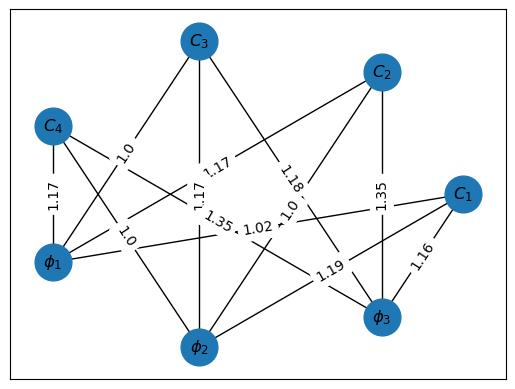

[[0.   0.   0.   0.   1.02 1.19 1.16]
 [0.   0.   0.   0.   1.17 1.   1.35]
 [0.   0.   0.   0.   1.   1.17 1.18]
 [0.   0.   0.   0.   1.17 1.   1.35]
 [1.02 1.17 1.   1.17 0.   0.   0.  ]
 [1.19 1.   1.17 1.   0.   0.   0.  ]
 [1.16 1.35 1.18 1.35 0.   0.   0.  ]]


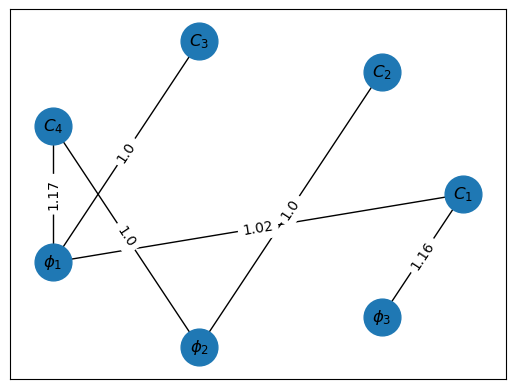

[[0.   0.   0.   0.   0.   0.   1.16]
 [0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   1.17 1.   0.  ]
 [1.02 0.   1.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.  ]]


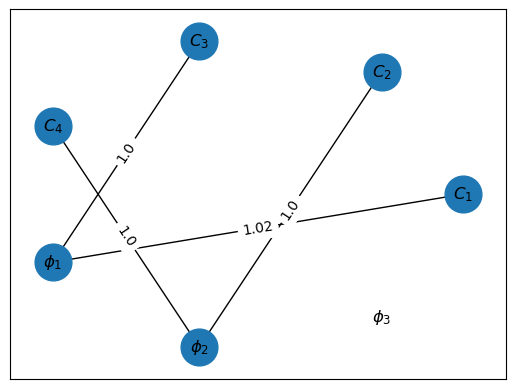

[[0.   0.   0.   0.   1.02 0.   0.  ]
 [0.   0.   0.   0.   0.   1.   0.  ]
 [0.   0.   0.   0.   1.   0.   0.  ]
 [0.   0.   0.   0.   0.   1.   0.  ]
 [1.02 0.   1.   0.   0.   0.   0.  ]
 [0.   1.   0.   1.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.  ]]

Estimation: [1 2 1 2]  True: [3 2 1 3]


In [247]:
clients = [r"$C_1$", r"$C_2$", r"$C_3$", r"$C_4$"]
phases = [r"$\phi_1$", r"$\phi_2$", r"$\phi_3$"]

node_labels = clients + phases

# recreating the data
n_customers = 4
phase = randint(1, 4, n_customers)
phase = np.array([3,2,1,3])
X,Y = createXY(raw_data,phase,sigma=0)

# create the matrix of the graph
matrix_graph = create_graph(X,Y,10,weight_normalized_sum,clients,phases)
display_graph(matrix_graph,node_labels)
print(matrix_form(matrix_graph))

# find the minimum spanning tree
mst = create_mst_graph(matrix_graph)
display_graph(mst,clients+phases)
print(matrix_form(mst))




# get the final graph, where we only take the min edges of each client
final_graph = get_final_graph(mst,clients)
display_graph(final_graph,clients+phases)
print(matrix_form(final_graph))

# now, from the final_graph, we can get the final assignment
assignment = get_final_assignment(final_graph,clients)
print('\nEstimation:',assignment,' True:',phase)

### Now, we do it for all frames.

/home/caria/anaconda3/lib/python3.10/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


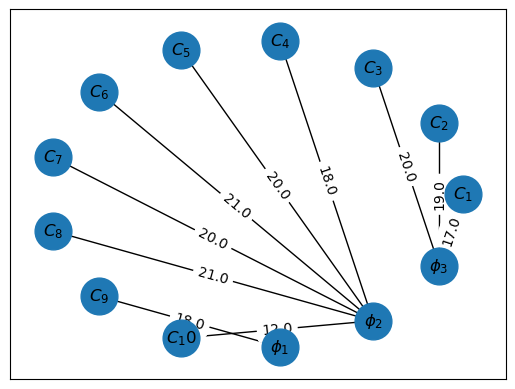

Estimation: [3 3 3 2 2 2 2 2 1 2] True: [3 1 3 1 1 1 3 3 1 2]
Right: 4 Wrong: 6


In [231]:
#clients = [r"$C_1$", r"$C_2$", r"$C_3$", r"$C_4$"]
#phases = [r"$\phi_1$", r"$\phi_2$", r"$\phi_3$"]

# recreating the data
n_customers = 10
n_phases = 3
phase = np.array([1,3,3,1])
phase = np.array([3,1,2,3])
phase = np.array([1,1,1,1])
phase = get_original_phase(n_phases,n_customers)
sigma = 0 # noise level
X,Y = createXY(raw_data,phase,sigma)


# automate the "clients" and "phases" string variables for the amount of clients and phases we pick
clients = [r"$C_{}$".format(i+1) for i in range(n_customers)]
phases = [r"$\phi_{}$".format(i+1) for i in range(n_phases)]

node_labels = clients + phases

matrix_global = np.zeros((len(node_labels),len(node_labels)))
# looping over all time steps
for k in range(X.shape[0]):

    # list of weights: weight_abs, weight_normalized_abs, weight_square, weight_normalized_square, weight_normalized_sum, weight_normalized
    # create the matrix of the graph
    matrix_graph = create_graph(X,Y,k,weight_normalized_abs,clients,phases) 

    # add it to the global matrix
    matrix_global += matrix_graph
#mst_global = create_mst_graph(matrix_global)
mst_global = prim(matrix_global)
#display_graph(mst_global,node_labels)
# get the final graph, where we only take the min edges of each client
final_graph = get_final_graph(mst_global,clients)

# get the final assignment
assignment = get_final_assignment(final_graph,clients)

# display the graph
display_graph(final_graph,node_labels)
# display the assignment
print('Estimation:',assignment,'True:',phase)
# print how many times we were right vs wrong
print('Right:',np.count_nonzero(assignment == phase),'Wrong:',np.count_nonzero(assignment != phase))

### Automating

In [240]:
def phase_id(weight_function,phase,sigma,plotQ=False,anounce_resultsQ=False,kruskal_or_prim='kruskal'):
    # automate the "clients" and "phases" string variables for the amount of clients and phases we pick
    n_customers = len(phase)
    n_phases = len(np.unique(phase))
    clients = [r"$C_{}$".format(i+1) for i in range(n_customers)]
    phases = [r"$\phi_{}$".format(i+1) for i in range(n_phases)]
    node_labels = clients + phases

    # recreating the data
    X,Y = createXY(raw_data,phase,sigma)

    matrix_global = np.zeros((len(node_labels),len(node_labels)))
    # looping over all time steps
    for k in range(X.shape[0]):

        # create the matrix of the graph
        matrix_graph = create_graph(X,Y,k,weight_function,clients,phases) 

        # add it to the global matrix
        matrix_global += matrix_graph
    #mst_global = create_mst_graph(matrix_global)
    if kruskal_or_prim == 'kruskal':
        mst_global = create_mst_graph(matrix_global)
    elif kruskal_or_prim == 'prim':
        mst_global = prim(matrix_global)
    else :
        print('Error: kruskal_or_prim must be either "kruskal" or "prim"')
        return None
    #display_graph(mst_global,node_labels)
    # get the final graph, where we only take the min edges of each client
    final_graph = get_final_graph(mst_global,clients)

    # get the final assignment
    assignment = get_final_assignment(final_graph,clients)

    # display the graph
    if plotQ:
        display_graph(final_graph,node_labels)
    # display the assignment
    if anounce_resultsQ:
        print('Estimation:',assignment,'\nTrue:',phase)
        # print how many times we were right vs wrong
        print('Right:',np.count_nonzero(assignment == phase),'Wrong:',np.count_nonzero(assignment != phase))
    return assignment

In [264]:
# recreating the data
n_customers = 4
n_phases = 3
phase = get_original_phase(n_phases,n_customers)
sigma = 0 # noise level

phase_id(weight_normalized_sum,phase,sigma,plotQ=False,anounce_resultsQ=True,kruskal_or_prim='kruskal'); # weight_normalized_abs works quite well

Estimation: [1 1 1 2] 
True: [3 3 1 2]
Right: 2 Wrong: 2


In [268]:
# noise parameter
sigma = (np.arange(0,0.6,0.1))**(1/2) # s.d.
#sigma = np.array([0])
# customer parameters
n_customers=[4,8,12]
n_phases=3
n_customer_plots=np.zeros((len(n_customers),len(sigma)))
current_plot=0
for nc in n_customers:
    
    phase = get_original_phase(n_phases,nc)  # establishing the phase results
    
    # iterating on each sigma^2 noise variance value
    plots_probs=np.zeros(len(sigma))
    for k in range(len(sigma)):
        
        # now we will iterate for the same noise sigma and number of clients nc
        # in order to estimate the error probability for such conditions
        n_exp=50 # such number of times
        list_probs=np.zeros(n_exp)
        for kk in range(n_exp): 
            
            # applying phase identification
            pred_phases = phase_id(weight_normalized_abs,phase,sigma[k],plotQ=False,anounce_resultsQ=False,kruskal_or_prim='kruskal')
            
            # evaluating the error of the prediction (true_B has the true values, pred_B has the predicted ones), we want the amount of times we were wrong, i.e. how many times phase and pred_phase are different
            # i.e. sum of times that phase and pred_phase are different
            dif_phase = phase-pred_phases
            prob_error=0
            for errorQ in dif_phase:
                if np.any(errorQ):
                    prob_error+=1/nc
                    
            # storing every atomic P(error) so we can average them out and get a better estimation
            list_probs[kk]=prob_error
        # storing this mean as our P(error) for 
        plots_probs[k]=list_probs.mean()
    # getting each plot of the P(error) for each number of customers nc        
    n_customer_plots[current_plot]=plots_probs
    current_plot+=1

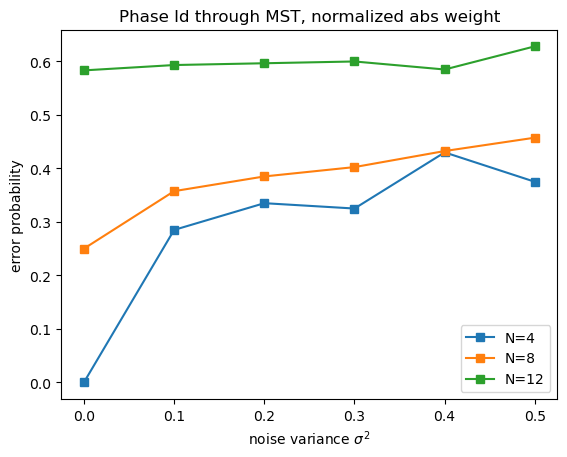

In [269]:
# finally plotting the error
fig, ax = plt.subplots()
ax.plot(sigma**2, n_customer_plots.T,'s-')

ax.legend(('N=4', 'N=8', 'N=12'))

ax.set(xlabel='noise variance $\sigma^2$', ylabel='error probability',
       title='Phase Id through MST, normalized abs weight')

plt.show()

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
clients = [r"$C_1$", r"$C_2$", r"$C_3$", r"$C_4$"]
phases = [r"$\phi_1$", r"$\phi_2$", r"$\phi_3$"]

node_labels = clients + phases
from scipy.stats import mode
assignment_list = []
# looping over all time steps
for k in range(X.shape[0]):
    # create the matrix of the graph
    matrix_graph = create_graph(X,Y,k,weight_abs,clients,phases)
    mst = create_mst_graph(matrix_graph)
    # get the final graph, where we only take the min edges of each client
    final_graph = get_final_graph(mst)
    # get the final assignment
    assignment = get_final_assignment(final_graph,clients)
    # save the assignment
    assignment_list.append(assignment)
# get the mode of the assignment
assignment_mode = mode(assignment_list,axis=0)[0][0]
# display the assignment
print('Estimation:',assignment_mode,'True:',phase_original)

Estimation: [1. 3. 2. 2.] True: [3, 2, 1, 3]


/tmp/ipykernel_361/2829456896.py:19: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  assignment_mode = mode(assignment_list,axis=0)[0][0]


In [ ]:
assignment_list

[array([1., 2., 3., 3.]),
 array([1., 1., 1., 2.]),
 array([1., 1., 3., 2.]),
 array([1., 3., 1., 2.]),
 array([3., 3., 2., 3.]),
 array([1., 3., 2., 2.]),
 array([3., 3., 2., 1.]),
 array([3., 3., 2., 3.]),
 array([3., 3., 2., 2.]),
 array([1., 2., 3., 2.]),
 array([3., 2., 3., 2.]),
 array([1., 2., 3., 2.])]